## Problema

Neste exercício vamos analisar dados de experimentos psicológicos sobre o problema do bondinho (Trolley problem), um dilema moral interessante na investigação do Utilitarismo.

Os dados que vamos usar estão em bondinho.csv e são apresentados e discutidos no capítulo 11 de Statistical Rethinking (SR).

Perguntas
Como você modelaria a relação entre a variável response e as outras covariáveis medidas no experimento? Que tipos de visualizações podem ser úteis antes de pôr a mão na massa?

Dados:

<li> response: morally permissible the participant found the action to be taken (or not) in the story

In [65]:
library(tidyverse)
library(GGally)  # ggpairs
library(MuMIn)  # AICc (Akaike Information Criterion corrected for small sample size)
library(readr)
library(ggplot2)
library(gridExtra)
library(rstanarm)
library(arm)
library(lattice)
library(lme4)
source("functions.r")

urlfile = "https://raw.githubusercontent.com/maxbiostat/stats_modelling/master/data/bondinho.csv"
data <- read_csv(url(urlfile))

Rows: 9930 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): case, id, edu, story
dbl (8): response, order, age, male, action, intention, contact, action2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
head(data)

case,response,order,id,age,male,edu,action,intention,contact,story,action2
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1
cispe,3,9,96;434,14,0,Middle School,0,1,1,spe,1


In [4]:
summary(data)

     case              response         order           id           
 Length:9930        Min.   :1.000   Min.   : 1.0   Length:9930       
 Class :character   1st Qu.:3.000   1st Qu.: 9.0   Class :character  
 Mode  :character   Median :4.000   Median :16.5   Mode  :character  
                    Mean   :4.199   Mean   :16.5                     
                    3rd Qu.:6.000   3rd Qu.:24.0                     
                    Max.   :7.000   Max.   :32.0                     
      age             male           edu                action      
 Min.   :10.00   Min.   :0.000   Length:9930        Min.   :0.0000  
 1st Qu.:26.00   1st Qu.:0.000   Class :character   1st Qu.:0.0000  
 Median :36.00   Median :1.000   Mode  :character   Median :0.0000  
 Mean   :37.49   Mean   :0.574                      Mean   :0.4333  
 3rd Qu.:48.00   3rd Qu.:1.000                      3rd Qu.:1.0000  
 Max.   :72.00   Max.   :1.000                      Max.   :1.0000  
   intention         contac

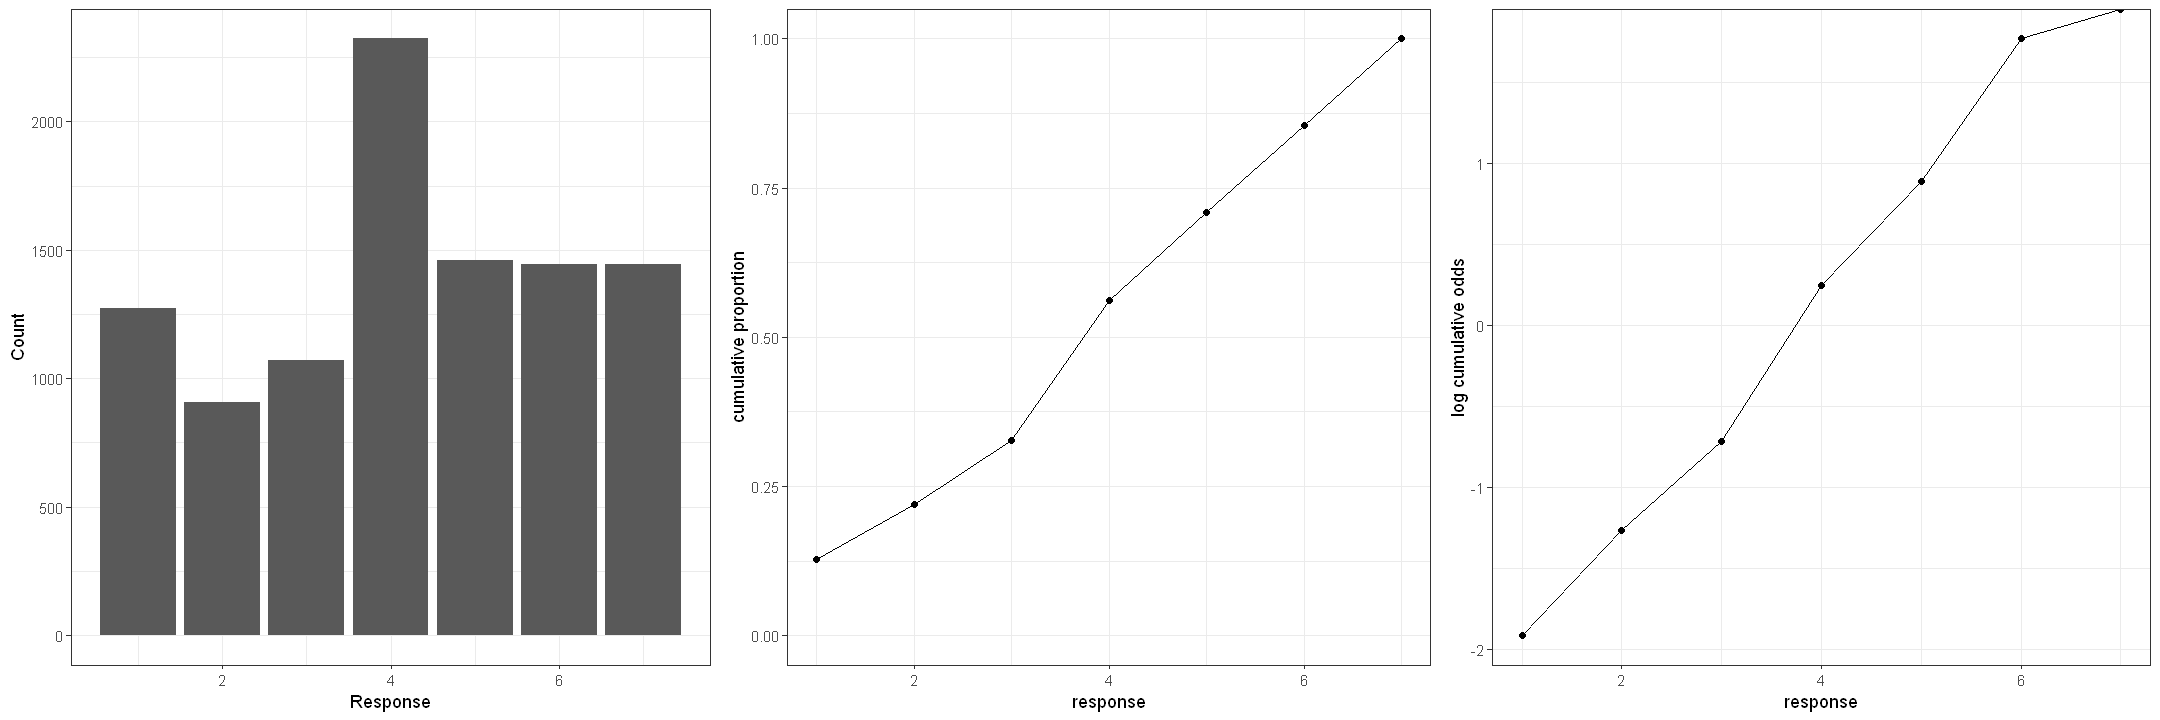

In [69]:
options(repr.plot.width = 18, repr.plot.height = 6)

histogram <- ggplot(data=data, aes(x=response)) + 
  geom_bar() +
  labs(x="Response", y="Count") +
  theme_bw() 

# Calculate the discrete proportion of each response value
pr_k <- table(data$response) / nrow(data)

# Calculate the cumulative proportions
cum_pr_k <- cumsum(pr_k)

# Create a data frame with x and y values
df <- data.frame(response = 1:7, cumulative_proportion = cum_pr_k)

# Create the cumulative proportion plot using ggplot
cumulative_proportion <- ggplot(df, aes(x = response, y = cumulative_proportion)) +
  geom_line() +
  geom_point() +
  labs(x = "response", y = "cumulative proportion") +
  theme_bw() +
  ylim(0, 1)



# Calculate the cumulative odds
cumulative_odds <- cumsum(pr_k) / (1 - cumsum(pr_k))

# Create a data frame with x and y values
df <- data.frame(response = 1:7, cumulative_odds = log(cumulative_odds))

# Create the log cumulative odds graph using ggplot
log_cumulative_odds <- ggplot(df, aes(x = response, y = cumulative_odds)) +
  geom_line() +
  geom_point() +
  theme_bw() +
  labs(x = "response", y = "log cumulative odds")

grid.arrange(histogram, cumulative_proportion, log_cumulative_odds, nrow=1)


\begin{aligned}
& y_i \sim \operatorname{CAT}\left(e_i\right) \\
& P_k =P_r\left(Y=y_k\right) \\
& p_i \in \mathbb{P} \subseteq \\
& =\operatorname{Pr}\left(Y \leq y_k\right)-\operatorname{Pr}\left(Y \leq y_{k-1}\right) \\
& \operatorname{logit}\left(p_k\right)=\alpha_k \Rightarrow \log _{T^{-1}}\left(\alpha_k\right)=p_k \\
& \alpha_{* \sim P_A(\cdot)}=\operatorname{Normal}(0,10) \\
&
\end{aligned}

\begin{aligned}
& \operatorname{logit} \left(P_k\right)=\log \left(\frac{P_k}{1-P_k}\right) \\
& =\log \left(\frac{\operatorname{Pr}\left(y=y_k\right)}{1-\operatorname{Pr}\left(y=y_x\right)}\right) \\
& =\log \left(\frac{a_{k}-a_{k-1}}{1-a_{k}+a_{k-1}}\right)=\alpha_k \\
&
\end{aligned}

In [13]:
logit <- function(x) log(x/(1-x)) # convenience function
round( lco <- logit( cum_pr_k ) , 2 )

1     2     3     4     5     6     7 
-1.92 -1.27 -0.72  0.25  0.89  1.77   Inf